In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from cryo_sbi.wpa_simulator.cryo_em_simulator import CryoEmSimulator

In [3]:
sim = CryoEmSimulator("image_params_mixed_training.json", device="cuda")

../data/protein_models/6wxb_mixed_models.npy


In [4]:
idx = torch.arange(0, 50, 1).repeat(5)

In [5]:
idx.ndim

1

In [6]:
%timeit images = sim.simulator(idx)

267 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
images = sim.simulator(idx)

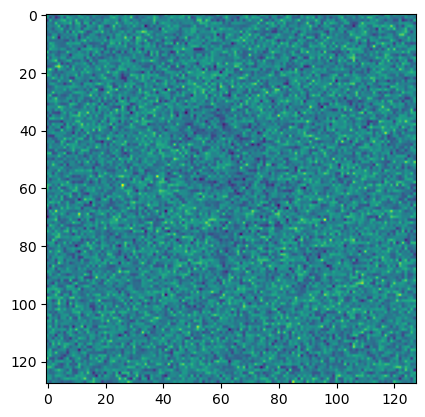

In [8]:
plt.imshow(images[10])

In [ ]:
plt.imshow(padded_image[0])

In [ ]:
torch.set_num_threads(1)

In [ ]:
config = json.load(open("../experiments/6wxb/image_params_mixed_training.json"))

In [ ]:
models = torch.from_numpy(np.load("../data/protein_models/6wxb_mixed_models.npy"))

In [ ]:
@torch.jit.script
def project_density(
    coord: torch.Tensor, sigma: float, num_pxels: int, pixel_size: float
) -> torch.Tensor:
    """
    Generate a 2D projection from a set of coordinates.

    Args:
        coord (torch.Tensor): Coordinates of the atoms in the image
        sigma (float): Standard deviation of the Gaussian function used to model electron density.
        num_pxels (int): Number of pixels along one image size.
        pixel_size (float): Pixel size in Angstrom

    Returns:
        image (torch.Tensor): Image generated from the coordinates
    """

    num_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * sigma**2 * num_atoms)

    grid_min = -pixel_size * (num_pxels - 1) * 0.5
    grid_max = pixel_size * (num_pxels - 1) * 0.5 + pixel_size

    grid = torch.arange(grid_min, grid_max, pixel_size, device=coord.device)

    gauss_x = torch.exp_(-0.5 * (((grid[:, None] - coord[0, :]) / sigma) ** 2))

    gauss_y = torch.exp_(-0.5 * (((grid[:, None] - coord[1, :]) / sigma) ** 2))

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

In [ ]:
%%timeit 
project_density(
    models[0],
    torch.tensor(2.0),#torch.tensor([1.0, 3.0, 2.5, 3.3]),
    torch.tensor(128),
    torch.tensor(2.0),
)

In [ ]:
plt.imshow(project_density(
    models[0],
    torch.tensor(2.0),#torch.tensor([1.0, 3.0, 2.5, 3.3]),
    torch.tensor(128),
    torch.tensor(2.0)
))

In [ ]:
def gen_img(coord: np.ndarray, image_params: dict) -> torch.Tensor:
    """
    Generate an image from a set of coordinates.

    Args:
        coord (np.ndarray): Coordinates of the atoms in the image
        image_params (dict): Dictionary containing the image parameters
            N_PIXELS (int): Number of pixels along one image size.
            PIXEL_SIZE (float): Pixel size in Angstrom
            SIGMA (float or list): Standard deviation of the Gaussian function used to model electron density.
            ELECWAVE (float): Electron wavelength in Angstrom

    Returns:
        image (torch.Tensor): Image generated from the coordinates
    """
    if coord.ndim == 2:
        shape = 1
    elif coord.ndim == 3:
        shape = coord.shape[0]

    if isinstance(image_params["SIGMA"], float):
        atom_sigma = image_params["SIGMA"]

    elif isinstance(image_params["SIGMA"], list) and len(image_params["SIGMA"]) == 2:
        atom_sigma = np.random.uniform(
            low=image_params["SIGMA"][0], high=image_params["SIGMA"][1], size=(1,)
        )

    else:
        raise ValueError(
            "SIGMA should be a single value or a list of [min_sigma, max_sigma]"
        )

    image = project_density(
        torch.from_numpy(coord),
        torch.from_numpy(atom_sigma),
        image_params["N_PIXELS"],
        image_params["PIXEL_SIZE"],
    )

    return image

In [ ]:
models = np.load("../data/protein_models/6wxb_mixed_models.npy")

In [ ]:
%%timeit 
gen_img(
    models[0],
    config
)

In [ ]:
from scipy.spatial.transform import Rotation

In [ ]:
Rotation.from_quat(quat).as_matrix()

In [ ]:
def gen_quat() -> torch.Tensor:
    """
    Generate a random quaternion.

    Returns:
        quat (np.ndarray): Random quaternion

    """
    count = 0
    while count < 1:
        quat = 2 * torch.rand(size=(4,)) - 1
        norm = torch.sqrt(torch.sum(quat**2))
        if 0.2 <= norm <= 1.0:
            quat /= norm
            count += 1

    return quat

In [ ]:
def gen_rot_matrix(quat: torch.Tensor) -> torch.Tensor:
    """
    Generate a rotation matrix from a quaternion.
    
    Args:
        quat (torch.Tensor): Quaternion
    
    Returns:
        rot_matrix (torch.Tensor): Rotation matrix
    """

    rot_matrix = torch.zeros((3, 3), device=quat.device)

    rot_matrix[0, 0] = 1 - 2 * (quat[2]**2 + quat[3]**2)
    rot_matrix[0, 1] = 2 * (quat[1] * quat[2] - quat[3] * quat[0])
    rot_matrix[0, 2] = 2 * (quat[1] * quat[3] + quat[2] * quat[0])

    rot_matrix[1, 0] = 2 * (quat[1] * quat[2] + quat[3] * quat[0])
    rot_matrix[1, 1] = 1 - 2 * (quat[1]**2 + quat[3]**2)
    rot_matrix[1, 2] = 2 * (quat[2] * quat[3] - quat[1] * quat[0])

    rot_matrix[2, 0] = 2 * (quat[1] * quat[3] - quat[2] * quat[0])
    rot_matrix[2, 1] = 2 * (quat[2] * quat[3] + quat[1] * quat[0])
    rot_matrix[2, 2] = 1 - 2 * (quat[1]**2 + quat[2]**2)

    return -rot_matrix

def gen_rot_matrix_batched(quats: torch.Tensor) -> torch.Tensor:
    """
    Generate a rotation matrix from a quaternion.
    
    Args:
        quat (torch.Tensor): Quaternion
    
    Returns:
        rot_matrix (torch.Tensor): Rotation matrix
    """

    rot_matrix = torch.zeros((quats.shape[0], 3, 3), device=quats.device)

    rot_matrix[:, 0, 0] = 1 - 2 * (quats[:, 2]**2 + quats[:, 3]**2)
    rot_matrix[:, 0, 1] = 2 * (quats[:, 1] * quats[:, 2] - quats[:, 3] * quats[:, 0])
    rot_matrix[:, 0, 2] = 2 * (quats[:, 1] * quats[:, 3] + quats[:, 2] * quats[:, 0])

    rot_matrix[:, 1, 0] = 2 * (quats[:, 1] * quats[:, 2] + quats[:, 3] * quats[:, 0])
    rot_matrix[:, 1, 1] = 1 - 2 * (quats[:, 1]**2 + quats[:, 3]**2)
    rot_matrix[:, 1, 2] = 2 * (quats[:, 2] * quats[:, 3] - quats[:, 1] * quats[:, 0])

    rot_matrix[:, 2, 0] = 2 * (quats[:, 1] * quats[:, 3] - quats[:, 2] * quats[:, 0])
    rot_matrix[:, 2, 1] = 2 * (quats[:, 2] * quats[:, 3] + quats[:, 1] * quats[:, 0])
    rot_matrix[:, 2, 2] = 1 - 2 * (quats[:, 1]**2 + quats[:, 2]**2)

    return -rot_matrix



In [ ]:
gen_rot_matrix_batched(gen_quat().unsqueeze(0))

In [ ]:
gen_rot_matrix_batched(quat)

In [ ]:
gen_rot_matrix(torch.tensor(quat))

In [ ]:
a = torch.tensor([1, 1, 2])

In [ ]:
torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])[a]

In [ ]:
import torch

In [ ]:
i = torch.randn((10, 256, 256))

In [ ]:
i[:, 10: 246, 10: 246].shape

In [18]:

def project_density(
    coord: torch.Tensor, sigma: float, num_pxels: int, pixel_size: float
) -> torch.Tensor:
    """
    Generate a 2D projection from a set of coordinates.

    Args:
        coord (torch.Tensor): Coordinates of the atoms in the image
        sigma (float): Standard deviation of the Gaussian function used to model electron density.
        num_pxels (int): Number of pixels along one image size.
        pixel_size (float): Pixel size in Angstrom

    Returns:
        image (torch.Tensor): Image generated from the coordinates
    """

    num_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * sigma**2 * num_atoms)

    grid_min = -pixel_size * (num_pxels - 1) * 0.5
    grid_max = pixel_size * (num_pxels - 1) * 0.5 + pixel_size

    grid = torch.arange(grid_min, grid_max, pixel_size, device=coord.device)

    gauss_x = torch.exp_(-0.5 * (((grid[:, None] - coord[0, :]) / sigma) ** 2))
    gauss_y = torch.exp_(-0.5 * (((grid[:, None] - coord[1, :]) / sigma) ** 2))

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

In [16]:
models = torch.from_numpy(np.load("../data/protein_models/6wxb_mixed_models.npy"))

In [17]:
%%timeit
mini_pro = project_density(
    models[0],
    2.0,
    80,
    2.06
)

2.97 ms ± 67.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
mini_pro = project_density(
    models[0],
    2.0,
    60,
    2.06
)

In [ ]:
%%timeit
mini_pro = project_density(
    models[0],
    2.0,
    128,
    2.06
)

In [ ]:
mini_pro = project_density(
    models[50],
    2.0,
    70,
    2.06
)
plt.imshow(mini_pro)

In [24]:
pixel_size = 2.06
num_pxels = 128
coord = models[50]
sigma=2

In [49]:
grid_min = -pixel_size * (num_pxels - 1) * 0.5
grid_max = pixel_size * (num_pxels - 1) * 0.5 + pixel_size

grid = torch.arange(grid_min, grid_max, pixel_size, device=coord.device)

In [50]:
%%timeit 
gauss_x = torch.exp_(-0.5 * (((grid[:, None] - coord[0, :]) / sigma) ** 2))
gauss_y = torch.exp_(-0.5 * (((grid[:, None] - coord[1, :]) / sigma) ** 2))

2.17 ms ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
%timeit image = torch.matmul(gauss_x, gauss_y.T)

1.22 ms ± 9.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
image = torch.matmul(gauss_x, gauss_y.T)

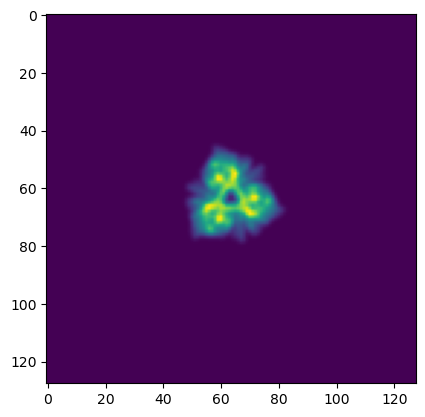

In [54]:
plt.imshow(image)